# Evaluate and predict customer churn
This notebook is an adaptation from the work done by [Sidney Phoon and Eleva Lowery](https://github.com/IBMDataScience/DSX-DemoCenter/tree/master/DSX-Local-Telco-Churn-master) with the following modifications:
* Use datasets persisted in DB2 Warehouse running on ICP
* Deploy and run the notebook on DSX enterprise running on IBM Cloud Private (ICP)
* Run spark Machine learning job on ICP as part of the worker nodes.
* Document some actions for a beginner data scienctist / developer who wants to understand what's going on.
* The web application was separated in another git project

The goal is still to demonstrate how to build a predictive model with Spark machine learning API (SparkML) to predict customer churn, and deploy it for scoring in Machine Learning (ML) running on ICP or within IBM public Cloud, Watson Machine Learning service.

## Scope
A lot of industries have the issue of customers moving to competitors when the product differentiation is not that important, or there is some customer support issues. One industry illustrating this problem is the telecom industry with mobile, internet and IP TV product offerings. 


## Note book explanations
The notebook aims to follow the classical data science modeling steps:
1. load the data
1. prepare the data
1. analyze the data (iterate on those two activities)
1. build a model
1. validate the accuracy of the model
1. deploy the model
1. consume the model as a service

This jupyter notebook uses Apache Spark to run the machine learning jobs to build decision trees and random forest classifier to assess when a customer is at risk to move to competitor. Apache Spark offers a Python module called pyspark to operate on data and use ML constructs.

### Start by all imports
As a best practices for notebook implementation is to do the import at the top of the notebook. 
* [Spark SQLContext](https://spark.apache.org/docs/latest/sql-programming-guide.html) a spark module to process structured data
* [spark conf]() to access Spark cluster configuration and then be able to execute queries
* [jaydebeapi](https://pypi.python.org/pypi/JayDeBeApi) is used to connect to the DB 2 warehouse where customer data are persisted. We assume they are loaded.
* [ibmdbpy](https://pypi.python.org/pypi/ibmdbpy) interface for data manipulation and access to in-database algorithms in IBM dashDB and IBM DB2.
* [pandas](https://pandas.pydata.org) Python super library for data analysis
* [brunel](https://github.com/Brunel-Visualization/Brunel/wiki) API and tool to visualize data quickly. 
* [pixiedust](www.ibm.com/PixieDust) Visualize data inside Jupyter notebooks

The first cell below is to execute some system commands to update the kernel with updated dependant library.

In [17]:
!pip install --user --upgrade pixiedust

Requirement already up-to-date: pixiedust in /user-home/1002/.local/lib/python2.7/site-packages
Requirement already up-to-date: lxml in /user-home/1002/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /opt/conda/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: mpld3 in /opt/conda/lib/python2.7/site-packages (from pixiedust)


In [18]:
from pyspark.sql import SQLContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark
import pandas as pd
import brunel
import numpy as np
from pixiedust.display import *

### Load data
We suppose the churn data were built by a marketing department who used the customer id and flag them as potential churn or not. The data are delivered as csv file to the data scientist.

There are two ways to work on the customer data in this notebook:
1. Upload the csv files in the DSX Object storage
2. Upload the data into Db2 warehouse.

In the code below the `sc` variable is the Spark Context, and it should be initialized by the execution of the notebook and the DSX spark kernel.

#### Using csv file
* Use the `+` icon on right side of the DSX menu bar to access to `Add Dataset` and then load the customer.csv and churn.csv files from the folder `refarch-analytics/notebooks/CustomerChurn/data_assets`. The churn attribute is just a boolean but the churn.csv file has the customer id referencing the customer in customer.csv. This is a join attribute.

Then change the next cell to be code and not markdown.

#### Add customer asset from file system
customers = SQLContext(sc).read.csv('../datasets/customer.csv', header='true',inferSchema='true')
customers.show(5)
customers.printSchema()
#### Add churn asset from file system
churns = SQLContext(sc).read.csv('../datasets/churn.csv', header='true',inferSchema='true')
churns.show(5)
churns.printSchema()

#### Using the Database: 
The explanation on how to upload the csv files to a Db2 warehouse is done in [this note](https://github.com/ibm-cloud-architecture/refarch-analytics/blob/master/notebooks/CustomerChurn/README.md#step-1--upload-data-to-db2-warehouse).
Once the data are loaded in the database, you need to do define the data set inside DSX as a remote data source. The steps are describes in [this note](https://github.com/ibm-cloud-architecture/refarch-analytics/blob/master/notebooks/CustomerChurn/README.md#step-2--define-remote-data-source-in-dsx). To summarize them here:
* Add data source in the project
* Specify the data set to reference the target table in the DB

The dsx_core_utils is a python library to access DSX capabilities, see the product documentation [here](https://datascience.ibm.com/docs/content/local/createdatasources.html)

In [19]:
import dsx_core_utils

dataSet = dsx_core_utils.get_remote_data_set_info('Customers')
dataSource = dsx_core_utils.get_data_source_info(dataSet['datasource'])
print(dataSource)
dbTableOrQuery = dataSet['schema'] + '.' + dataSet['table']
print(dbTableOrQuery)
sparkSession = SparkSession(sc).builder.getOrCreate()
customers = sparkSession.read.format("jdbc").option("url", dataSource['URL']).option("dbtable",dbTableOrQuery).option("user",'BLUADMIN').option("password","changemeplease").load()
customers.show(5)
churns = SQLContext(sc).read.csv('../datasets/churn.csv', header='true',inferSchema='true') 
churns.show(5) 
churns.printSchema()

{u'description': u'', u'URL': u'jdbc:db2://172.16.40.131:32166/BLUDB', 'driver_class': 'com.ibm.db2.jcc.DB2Driver', u'dsx_artifact_type': u'datasource', u'shared': True, u'type': u'DB2', u'name': u'CustomerLongDataSource'}
BLUADMIN.CUSTOMERLONG
+----+------+------+--------+----------+---------+---------+------------+-------------+-----+-------+---------+-------------+--------------------+-----+--------+
|  ID|GENDER|STATUS|CHILDREN|EST_INCOME|CAR_OWNER|      AGE|LONGDISTANCE|INTERNATIONAL|LOCAL|DROPPED|PAYMETHOD|LOCALBILLTYPE|LONGDISTANCEBILLTYPE|USAGE|RATEPLAN|
+----+------+------+--------+----------+---------+---------+------------+-------------+-----+-------+---------+-------------+--------------------+-----+--------+
|2388|     F|     S|       0|  93322.10|        Y|40.313333|       29.92|         0.00| 8.79|      0|       CH|       Budget|      Intnl_discount|38.72|       1|
|2391|     M|     M|       2|  49910.70|        Y|51.520000|       27.42|         0.00|23.72|      0|      

When the previous code run successfully you will see the top five rows of each dataset, and the schema infered by looking at the data.

One of the major question to address is what are the attributes of this dataset that are relevant to classify churn risk.  

### Prepare data
To have a unique dataset to split into training and test sets, we need to merge the churn and customer tables in one dataset also named DataFrame. The ID attribute represents the customer ID and is used as join column. 


In [20]:
data=customers.join(churns,customers['ID']==churns['ID']).select(customers['*'],churns['CHURN'])
data.show(5)


+----+------+------+--------+----------+---------+---------+------------+-------------+-----+-------+---------+-------------+--------------------+-----+--------+-----+
|  ID|GENDER|STATUS|CHILDREN|EST_INCOME|CAR_OWNER|      AGE|LONGDISTANCE|INTERNATIONAL|LOCAL|DROPPED|PAYMETHOD|LOCALBILLTYPE|LONGDISTANCEBILLTYPE|USAGE|RATEPLAN|CHURN|
+----+------+------+--------+----------+---------+---------+------------+-------------+-----+-------+---------+-------------+--------------------+-----+--------+-----+
|2388|     F|     S|       0|  93322.10|        Y|40.313333|       29.92|         0.00| 8.79|      0|       CH|       Budget|      Intnl_discount|38.72|       1|    T|
|2391|     M|     M|       2|  49910.70|        Y|51.520000|       27.42|         0.00|23.72|      0|       CC|       Budget|            Standard|51.14|       3|    F|
|2392|     M|     M|       0|  76161.40|        Y|44.573333|       11.96|         0.00|25.58|      0|       CC|    FreeLocal|            Standard|37.55|       1

As part of data preparation we can rename columns or remove columns redudant or not usefule for the classification model development. 

In [21]:
# Rename columns
data = data.withColumnRenamed("Est Income", "EstIncome").withColumnRenamed("Car Owner","CarOwner")
# Remove unnecessary columns
data.drop('ID').collect()
# If during the data loading you discovered an attribute is using a wrong type you can use the following Spark DataFrame API to change the model
# from pyspark.sql.types import DoubleType,IntegerType
# data = data.withColumn("Age",data["Age"].cast(IntegerType()))


[Row(GENDER=u'F', STATUS=u'S', CHILDREN=0, EST_INCOME=Decimal('64319.20'), CAR_OWNER=u'N', AGE=Decimal('41.226667'), LONGDISTANCE=Decimal('3.01'), INTERNATIONAL=Decimal('0.00'), LOCAL=Decimal('37.15'), DROPPED=0, PAYMETHOD=u'CH', LOCALBILLTYPE=u'Budget', LONGDISTANCEBILLTYPE=u'Intnl_discount', USAGE=Decimal('40.16'), RATEPLAN=1, CHURN=u'T'),
 Row(GENDER=u'F', STATUS=u'S', CHILDREN=1, EST_INCOME=Decimal('73338.00'), CAR_OWNER=u'N', AGE=Decimal('48.246667'), LONGDISTANCE=Decimal('20.92'), INTERNATIONAL=Decimal('0.00'), LOCAL=Decimal('9.01'), DROPPED=0, PAYMETHOD=u'Auto', LOCALBILLTYPE=u'Budget', LONGDISTANCEBILLTYPE=u'Intnl_discount', USAGE=Decimal('29.93'), RATEPLAN=1, CHURN=u'T'),
 Row(GENDER=u'F', STATUS=u'S', CHILDREN=0, EST_INCOME=Decimal('433.74'), CAR_OWNER=u'N', AGE=Decimal('60.746667'), LONGDISTANCE=Decimal('3.30'), INTERNATIONAL=Decimal('0.00'), LOCAL=Decimal('40.91'), DROPPED=0, PAYMETHOD=u'CC', LOCALBILLTYPE=u'FreeLocal', LONGDISTANCEBILLTYPE=u'Standard', USAGE=Decimal('44.22

### Data Visualization
Data preparation and data understanding are the most time-consuming tasks in the data mining process. 

The data scientist needs to review and evaluate the quality of data before modeling. 

Visualization is one of the ways to review data. 

The Brunel Visualization Language is a highly succinct and novel language that defines interactive data visualizations based on tabular data. The language is well suited for both data scientists and business users. More information about Brunel Visualization: https://github.com/Brunel-Visualization/Brunel/wiki Try Brunel visualization here: http://brunel.mybluemix.net/gallery_app/renderer

But as most of python library it uses Pandas dataframe. Hopefully Spark DataFrame has an api to convert to Pandas data frame. 

In [22]:
pdf = data.toPandas()
pdf.head()
pdf.describe()

,ID,CHILDREN,DROPPED,RATEPLAN
count,2065.000000,2065.000000,2065.000000,2065.000000
mean,1903.741889,1.146247,0.136077,2.510412
std,1094.284948,0.843303,0.526784,1.124952
min,6.000000,0.000000,0.000000,1.000000
25%,974.000000,0.000000,0.000000,2.000000
50%,1882.000000,1.000000,0.000000,2.000000
75%,2834.000000,2.000000,0.000000,4.000000
max,3825.000000,2.000000,4.000000,4.000000


Compute some interesting values using Python numpy library

In [23]:

print('The mean of the usage is %d ' % np.mean(pdf['USAGE']))
print('The mean of the age is %d ' % np.mean(pdf['AGE']))
      

The mean of the usage is 75 
The mean of the age is 42 


In [24]:
import brunel

%brunel data('pdf') bar x(CHURN) y(EST_INCOME) mean(EST_INCOME) color(LOCALBILLTYPE) stack tooltip(EST_INCOME) | x(LONGDISTANCE) y(USAGE) point color(PAYMETHOD) tooltip(LONGDISTANCE, USAGE) :: width=1100, height=400

<IPython.core.display.Javascript object>

From the previous diagrams, higher revenue customers seem to stay more.

### PixieDust
PixieDust is a Python Helper library for Spark IPython Notebooks. One of its main features are visualizations. You'll notice that unlike other APIs which produce just output, PixieDust creates an interactive UI in which you can explore data. As PixieDust uses numerical values and some of the panda dataframe were still strings, we need to do some data transformation. 
Also the pixiesdust needs a panda dataframe.


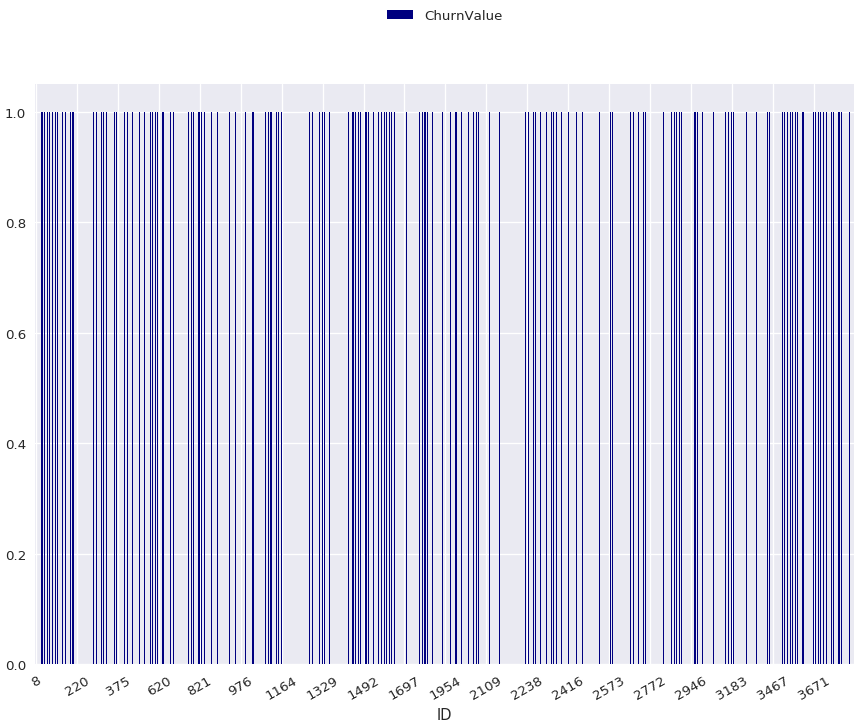

In [25]:
b={'T':1,'F':0}
pdf['ChurnValue']=pdf['CHURN'].map(b)
display(pdf)

## Prepare the decision trees and Random Forest with Spark
"Pipeline" is an API in SparkML that's used for building models. See spark machine learning library [documentation](https://spark.apache.org/docs/2.0.2/ml-guide.html) and [pipeline guide](https://spark.apache.org/docs/2.0.2/ml-pipeline.html). Spark uses DataFrame API since 2.0. 
The code below encodes all attributes that are labels of type string to indexed numberical value. We need that for ML processing.


**StringIndexer** encodes a string column of labels to a column of label indices. The indices are in (0, numLabels), ordered by label frequencies, so the most frequent label gets index 0.

**OneHotEncoder** maps a column of label indices to a column of binary vectors, with at most a single one-value. This encoding allows algorithms which expect continuous features, such as Logistic Regression, to use categorical features.

**VectorAssembler** is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees

In [30]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

# Prepare string variables so that they can be used by the decision tree algorithm
# StringIndexer encodes a string column of labels to a column of label indices
SI1 = StringIndexer(inputCol='GENDER', outputCol='GenderEncoded')
SI2 = StringIndexer(inputCol='STATUS',outputCol='StatusEncoded')
SI3 = StringIndexer(inputCol='CAR_OWNER',outputCol='CarOwnerEncoded')
SI4 = StringIndexer(inputCol='PAYMETHOD',outputCol='PaymethodEncoded')
SI5 = StringIndexer(inputCol='LOCALBILLTYPE',outputCol='LocalBilltypeEncoded')
SI6 = StringIndexer(inputCol='LONGDISTANCEBILLTYPE',outputCol='LongDistanceBilltypeEncoded')
labelIndexer = StringIndexer(inputCol='CHURN', outputCol='label').fit(data)

#Apply OneHotEncoder so categorical features aren't given numeric importance
OH1 = OneHotEncoder(inputCol="GenderEncoded", outputCol="GenderEncoded"+"classVec")
OH2 = OneHotEncoder(inputCol="StatusEncoded", outputCol="StatusEncoded"+"classVec")
OH3 = OneHotEncoder(inputCol="CarOwnerEncoded", outputCol="CarOwnerEncoded"+"classVec")
OH4 = OneHotEncoder(inputCol="PaymethodEncoded", outputCol="PaymethodEncoded"+"classVec")
OH5 = OneHotEncoder(inputCol="LocalBilltypeEncoded", outputCol="LocalBilltypeEncoded"+"classVec")
OH6 = OneHotEncoder(inputCol="LongDistanceBilltypeEncoded", outputCol="LongDistanceBilltypeEncoded"+"classVec")

# Pipelines API requires that input variables are passed in  a vector
assembler = VectorAssembler(inputCols=["GenderEncodedclassVec", "StatusEncodedclassVec", "CarOwnerEncodedclassVec", \
                                       "PaymethodEncodedclassVec", "LocalBilltypeEncodedclassVec", \
                                       "LongDistanceBilltypeEncodedclassVec", "CHILDREN", "EST_INCOME", "AGE", \
                                       "LONGDISTANCE", "INTERNATIONAL", "LOCAL",\
                                       "DROPPED","USAGE","RATEPLAN"], outputCol="features")

A pipeline is like a work flow to combine a set of operations or algorithm to apply on the data. It chains transformers and estimators. Transformers are used to convert DataFrame to another by appending one or more columns. Estimators are learning algorithm that train (or fit) on data.
In machine learning, it is common to run a sequence of algorithms to process and learn from data.
A Pipeline is a sequence of stages, and each stage is either a Transformer or an Estimator. These stages are run in order, and the input DataFrame is transformed as it passes through each stage. A pipeline is an estimator, but produces a transformation.

In [31]:
# instantiate the ramdom forest classifier algorithm, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,labelIndexer, OH1, OH2, OH3, OH4, OH5, OH6,assembler, rf, labelConverter])
# pipeline = Pipeline(stages=[SI1,SI2,SI3,SI4,SI5,SI6,labelIndexer, OH1, OH2, OH3, OH4, OH5, OH6,assembler,rf])

In [32]:

# Split data into train and test datasets
train, test = data.randomSplit([0.8,0.2], seed=6)
train.cache()
test.cache()

DataFrame[ID: int, GENDER: string, STATUS: string, CHILDREN: int, EST_INCOME: decimal(8,2), CAR_OWNER: string, AGE: decimal(14,6), LONGDISTANCE: decimal(6,2), INTERNATIONAL: decimal(5,2), LOCAL: decimal(7,2), DROPPED: int, PAYMETHOD: string, LOCALBILLTYPE: string, LONGDISTANCEBILLTYPE: string, USAGE: decimal(7,2), RATEPLAN: int, CHURN: string]

In [33]:
# Build models
model = pipeline.fit(train)

## Score the model with the test set

In [34]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

results = model.transform(test)
results=results.select(results["ID"],results["CHURN"],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)
# Evaluate the model

print 'Precision model1 = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count()))


# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label", metricName="areaUnderROC")
print 'Area under ROC curve = {:.2f}.'.format(evaluator.evaluate(results))

Precision model1 = 0.93.
Area under ROC curve = 0.92.


We have finished building and testing a predictive model. The next step is to deploy it for real time scoring.
## Save Model in ML repository